Imports:

In [118]:
import pandas as pd
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, GlobalMaxPooling1D, Conv1D, BatchNormalization, MaxPooling1D, Flatten, Input
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

import prettytable

import matplotlib.pyplot as plt
%matplotlib inline

from word2vec import *

Load Dataset: 

In [34]:
suicide_detection_df = pd.read_csv('Data/Suicide_Detection_Final.csv', header=0)
suicide_detection_df.replace({"class": {"suicide": 1, "non-suicide": 0}}, inplace=True)
suicide_detection_df.drop(columns=['text'], inplace=True)
suicide_detection_df = suicide_detection_df.rename(columns={"cleaned_text": "text"})
suicide_detection_df
     

,class,text
0,1,sex wife threaten suicide recently leave wife ...
1,0,weird not get affected compliment come someone...
2,0,finally almost never hear bad year ever swear ...
3,1,need help help cry hard
4,1,end tonight can not anymore quit
...,...,...
174219,0,something today go sled friend may not seem li...
174220,0,not like rock not go get anything go
174221,0,tell many friend not lonely everything deprive...
174222,0,pee probably taste like salty tea someone drin...


In [35]:
SEED = 4222
EPOCHS = 5     

In [36]:
# Split dataset into train, validation and test sets
train_text, test_text, train_labels, test_labels = train_test_split(suicide_detection_df['text'], suicide_detection_df['class'],
                                                                    random_state=SEED,
                                                                    test_size=0.2,
                                                                    stratify=suicide_detection_df['class'])
     

Create lists out of data:


In [37]:
train_text_list = train_text.to_list()
test_text_list = test_text.to_list()

### Create Word2Vec Embeddings

In [41]:
model = build_and_train_w2v(train_text, 'Data/vocab.txt', size=100, window=10, min_count=1, seed=SEED)

Created vocab
Filtered data


In [15]:
# save model in ASCII (word2vec) format
filename = 'Data/embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

In [16]:
model.wv["sad"]

array([ 0.9773388 , -0.79447114,  1.3530589 , -2.7581582 ,  0.5749639 ,
        0.8760257 , -0.0263493 ,  0.30944148,  1.1790156 , -2.1728652 ,
        1.4526525 ,  0.0300597 , -0.91938573,  1.7271922 ,  1.858517  ,
        1.1788456 ,  1.2480174 , -0.61717635, -0.88342243,  1.9072415 ,
        0.3122152 , -0.36911514, -1.498514  , -1.0652018 , -0.8949371 ,
       -2.6556225 , -1.0424315 , -0.64992976, -1.5206785 , -0.26523888,
       -0.5489853 , -0.5065771 ,  0.51189196,  0.7043124 ,  2.5573    ,
       -2.8354106 ,  1.0097511 , -0.99265486,  1.1465017 , -0.9919296 ,
       -2.762761  ,  0.22080773,  2.5458305 , -1.0009484 , -0.09977311,
       -2.1108735 , -1.456767  ,  0.59842616, -1.5876533 ,  0.50874317,
       -0.03524625, -0.6297616 , -2.087734  ,  0.8002677 , -0.23586479,
        0.18074411,  0.02644702, -0.07640674,  1.1297915 ,  1.81205   ,
       -0.08904827,  0.64148474, -1.1347479 , -0.22442636,  0.7230523 ,
        0.63385606,  1.2472035 , -0.41576102,  0.39601782, -0.24

In [17]:
model.wv.most_similar('suicide')

[('ruhr', 0.6136550903320312),
 ('physiologist', 0.585098385810852),
 ('furtherance', 0.569932758808136),
 ('arson', 0.5661197304725647),
 ('suicidal', 0.5598054528236389),
 ('involuntarily', 0.5566613674163818),
 ('unsuccessful', 0.5402469635009766),
 ('hgsdjasoihatelifegdbhsjjnhdgskjlkvfdhkj', 0.5098829865455627),
 ('broadcaster', 0.5086207389831543),
 ('kill', 0.5062658190727234)]

In [59]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text_list)

X_train = tokenizer.texts_to_sequences(train_text_list)
X_test = tokenizer.texts_to_sequences(test_text_list)

In [60]:
vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences to a fixed length
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [61]:
# Embedding the words using the WORD2VEC 
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]

## Create the NN Models

In [62]:
early_stopping = EarlyStopping(monitor="val_loss", patience=2, verbose=1, restore_best_weights=True)

### Model 1: 

In [72]:
cnn_model1 = Sequential()
cnn_model1.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
cnn_model1.add(Conv1D(128, 5, activation='relu'))
cnn_model1.add(MaxPooling1D(5))
cnn_model1.add(Dropout(0.5)) 
cnn_model1.add(Conv1D(128, 5, activation='relu'))
cnn_model1.add(MaxPooling1D(5))
cnn_model1.add(Dropout(0.5)) 
cnn_model1.add(Flatten())
cnn_model1.add(Dense(128, activation='relu'))
cnn_model1.add(Dropout(0.5))
cnn_model1.add(Dense(1, activation='sigmoid'))

cnn_model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn1_history = cnn_model1.fit(X_train, train_labels, epochs=10, batch_size=32, validation_data=(X_test, test_labels), callbacks=[early_stopping])

Epoch 1/10
4356/4356 [==============================] - 70s 16ms/step - loss: 0.2647 - accuracy: 0.8992 - val_loss: 0.2215 - val_accuracy: 0.9166
Epoch 2/10
4356/4356 [==============================] - 72s 16ms/step - loss: 0.2377 - accuracy: 0.9110 - val_loss: 0.2256 - val_accuracy: 0.9156
Epoch 3/10
4356/4356 [==============================] - 71s 16ms/step - loss: 0.2346 - accuracy: 0.9133 - val_loss: 0.2183 - val_accuracy: 0.9216
Epoch 4/10
4356/4356 [==============================] - 73s 17ms/step - loss: 0.2300 - accuracy: 0.9160 - val_loss: 0.2288 - val_accuracy: 0.9229
Epoch 5/10
4356/4356 [==============================] - 69s 16ms/step - loss: 0.2280 - accuracy: 0.9161 - val_loss: 0.2176 - val_accuracy: 0.9227
Epoch 6/10
4356/4356 [==============================] - 76s 17ms/step - loss: 0.2262 - accuracy: 0.9170 - val_loss: 0.2294 - val_accuracy: 0.9230
Epoch 7/10
4356/4356 [==============================] - 75s 17ms/step - loss: 0.2240 - accuracy: 0.9177 - val_loss: 0.2385 -

In [112]:
# Save the model
cnn_model1.save('Models/CNN_model1.h5')

### Model 2:
- Altered the `dropout_rate` to 0.2
- Added batch normalization, which normalized the inputs of the layer for each batch.

In [75]:
cnn_model2 = Sequential()
cnn_model2.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
cnn_model2.add(Conv1D(128, 5, activation='relu'))
cnn_model2.add(MaxPooling1D(5))
cnn_model2.add(BatchNormalization())
cnn_model2.add(Dropout(0.2))
cnn_model2.add(Conv1D(128, 5, activation='relu'))
cnn_model2.add(MaxPooling1D(5))
cnn_model2.add(BatchNormalization())
cnn_model2.add(Dropout(0.2))
cnn_model2.add(Flatten())
cnn_model2.add(Dense(128, activation='relu'))
cnn_model2.add(Dropout(0.2))
cnn_model2.add(Dense(1, activation='sigmoid'))

cnn_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn2_history = cnn_model2.fit(X_train, train_labels, epochs=10, batch_size=32, validation_data=(X_test, test_labels), callbacks=[early_stopping])

Epoch 1/10
4356/4356 [==============================] - 95s 21ms/step - loss: 0.2390 - accuracy: 0.9072 - val_loss: 0.2083 - val_accuracy: 0.9204
Epoch 2/10
4356/4356 [==============================] - 81s 19ms/step - loss: 0.2099 - accuracy: 0.9204 - val_loss: 0.2012 - val_accuracy: 0.9231
Epoch 3/10
4356/4356 [==============================] - 89s 20ms/step - loss: 0.1961 - accuracy: 0.9256 - val_loss: 0.1953 - val_accuracy: 0.9260
Epoch 4/10
4356/4356 [==============================] - 93s 21ms/step - loss: 0.1831 - accuracy: 0.9305 - val_loss: 0.1924 - val_accuracy: 0.9263
Epoch 5/10
4356/4356 [==============================] - 85s 19ms/step - loss: 0.1712 - accuracy: 0.9356 - val_loss: 0.2092 - val_accuracy: 0.9227
Epoch 6/10
4356/4356 [==============================] - 80s 18ms/step - loss: 0.1595 - accuracy: 0.9402 - val_loss: 0.2143 - val_accuracy: 0.9232
Epoch 6: early stopping


In [113]:
# Save the model
cnn_model2.save('Models/CNN_model2.h5')

### Model 3: 
- Altered `dropout rate` to 0.1
- Second convolutional layer's kernel_size changed to 6.
- Regularization in the dense layer using `l2` regularization. 

In [80]:
cnn_model3 = Sequential()
cnn_model3.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
cnn_model3.add(Conv1D(128, 5, activation='relu'))
cnn_model3.add(MaxPooling1D(5))
cnn_model3.add(BatchNormalization())
cnn_model3.add(Dropout(0.1))
cnn_model3.add(Conv1D(128, 6, activation='relu'))
cnn_model3.add(MaxPooling1D(5))
cnn_model3.add(BatchNormalization())
cnn_model3.add(Dropout(0.1))
cnn_model3.add(Flatten())
cnn_model3.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model3.add(Dropout(0.1))
cnn_model3.add(Dense(1, activation='sigmoid'))

cnn_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn3_history = cnn_model3.fit(X_train, train_labels, epochs=10, batch_size=32, validation_data=(X_test, test_labels), callbacks=[early_stopping])

Epoch 1/10
4356/4356 [==============================] - 69s 15ms/step - loss: 0.3073 - accuracy: 0.9066 - val_loss: 0.2217 - val_accuracy: 0.9213
Epoch 2/10
4356/4356 [==============================] - 72s 16ms/step - loss: 0.2272 - accuracy: 0.9181 - val_loss: 0.2171 - val_accuracy: 0.9209
Epoch 3/10
4356/4356 [==============================] - 72s 16ms/step - loss: 0.2100 - accuracy: 0.9251 - val_loss: 0.2125 - val_accuracy: 0.9224
Epoch 4/10
4356/4356 [==============================] - 75s 17ms/step - loss: 0.1954 - accuracy: 0.9306 - val_loss: 0.2140 - val_accuracy: 0.9225
Epoch 5/10
4356/4356 [==============================] - 78s 18ms/step - loss: 0.1821 - accuracy: 0.9367 - val_loss: 0.2178 - val_accuracy: 0.9215
Epoch 5: early stopping


In [114]:
cnn_model3.save('Models/CNN_model3.h5')

### Model 4: 
- Added an `LSTM` layer with 30 units.
- Added a `GlobalMaxPooling1D` layer to the model.
- Removed `Flatten`, `Dropout` and `BatchNormalization` layers.
- Added a `ReduceLROnPlateau` callback to the model.
- Increased `epochs` and `batch_size`.
- Increased `patience` in the `EarlyStopping` callback.

In [89]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Define learning rate reduction on plateau callback
reducelr = ReduceLROnPlateau(patience=3, verbose=1)

# Define the CNN model
cnn_model4 = Sequential()
cnn_model4.add(Input(shape=(max_length,)))
cnn_model4.add(Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False))
cnn_model4.add(LSTM(20, return_sequences=True))
cnn_model4.add(GlobalMaxPooling1D())
cnn_model4.add(Dense(256, activation='relu'))
cnn_model4.add(Dense(1, activation='sigmoid'))

cnn_model4.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
cnn4_history = cnn_model4.fit(X_train, train_labels, epochs=20, batch_size=256, validation_data=(X_test, test_labels), callbacks=[early_stopping, reducelr])

Epoch 1/20
545/545 [==============================] - 39s 68ms/step - loss: 0.2240 - accuracy: 0.9118 - val_loss: 0.2013 - val_accuracy: 0.9229 - lr: 0.1000
Epoch 2/20
545/545 [==============================] - 37s 68ms/step - loss: 0.1912 - accuracy: 0.9269 - val_loss: 0.1899 - val_accuracy: 0.9276 - lr: 0.1000
Epoch 3/20
545/545 [==============================] - 35s 64ms/step - loss: 0.1844 - accuracy: 0.9293 - val_loss: 0.1908 - val_accuracy: 0.9265 - lr: 0.1000
Epoch 4/20
545/545 [==============================] - 35s 65ms/step - loss: 0.1788 - accuracy: 0.9319 - val_loss: 0.1889 - val_accuracy: 0.9289 - lr: 0.1000
Epoch 5/20
545/545 [==============================] - 33s 61ms/step - loss: 0.1744 - accuracy: 0.9337 - val_loss: 0.1865 - val_accuracy: 0.9290 - lr: 0.1000
Epoch 6/20
545/545 [==============================] - 34s 63ms/step - loss: 0.1709 - accuracy: 0.9349 - val_loss: 0.1863 - val_accuracy: 0.9290 - lr: 0.1000
Epoch 7/20
545/545 [==============================] - 34s 

In [115]:
cnn_model4.save('Models/CNN_model4.h5')

In [130]:
# CNN with Bidirectional LSTM
from keras.layers import Bidirectional

cnn_model5 = Sequential()
cnn_model5.add(Input(shape=(max_length,)))
cnn_model5.add(Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False))
cnn_model5.add(Bidirectional(LSTM(20, return_sequences=True)))
cnn_model5.add(GlobalMaxPooling1D())
cnn_model5.add(Dense(256, activation='relu'))
cnn_model5.add(Dense(1, activation='sigmoid'))

cnn_model5.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
cnn5_history = cnn_model5.fit(X_train, train_labels, epochs=20, batch_size=256, validation_data=(X_test, test_labels), callbacks=[early_stopping, reducelr])


Epoch 1/20
545/545 [==============================] - 64s 110ms/step - loss: 0.2188 - accuracy: 0.9137 - val_loss: 0.1951 - val_accuracy: 0.9253 - lr: 0.1000
Epoch 2/20
545/545 [==============================] - 57s 105ms/step - loss: 0.1882 - accuracy: 0.9278 - val_loss: 0.1937 - val_accuracy: 0.9245 - lr: 0.1000
Epoch 3/20
545/545 [==============================] - 61s 112ms/step - loss: 0.1792 - accuracy: 0.9315 - val_loss: 0.1942 - val_accuracy: 0.9250 - lr: 0.1000
Epoch 4/20
545/545 [==============================] - 63s 115ms/step - loss: 0.1722 - accuracy: 0.9343 - val_loss: 0.1897 - val_accuracy: 0.9261 - lr: 0.1000
Epoch 5/20
545/545 [==============================] - 63s 116ms/step - loss: 0.1669 - accuracy: 0.9363 - val_loss: 0.1842 - val_accuracy: 0.9300 - lr: 0.1000
Epoch 6/20
545/545 [==============================] - 63s 116ms/step - loss: 0.1620 - accuracy: 0.9389 - val_loss: 0.1862 - val_accuracy: 0.9296 - lr: 0.1000
Epoch 7/20
545/545 [==============================] 

In [132]:
# Save the model
cnn_model5.save('Models/CNN_model5.h5')

/Users/daniellazabari/Desktop/NLP_final_project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Choosing the best model

In [100]:
def compute_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    return accuracy, f1, precision, recall


In [101]:
# Create a prettytable object
table = prettytable.PrettyTable()

# Set the column names
table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1-Score"]

# Add data to the table
cnn1_accuracy, cnn1_f1, cnn1_precision, cnn1_recall = compute_metrics(cnn_model1, X_test, test_labels)
table.add_row(["CNN Model 1", cnn1_accuracy, cnn1_precision, cnn1_recall, cnn1_f1])

cnn2_accuracy, cnn2_f1, cnn2_precision, cnn2_recall = compute_metrics(cnn_model2, X_test, test_labels)
table.add_row(["CNN Model 2", cnn2_accuracy, cnn2_precision, cnn2_recall, cnn2_f1])

cnn3_accuracy, cnn3_f1, cnn3_precision, cnn3_recall = compute_metrics(cnn_model3, X_test, test_labels)
table.add_row(["CNN Model 3", cnn3_accuracy, cnn3_precision, cnn3_recall, cnn3_f1])

cnn4_accuracy, cnn4_f1, cnn4_precision, cnn4_recall = compute_metrics(cnn_model4, X_test, test_labels)
table.add_row(["CNN Model 4", cnn4_accuracy, cnn4_precision, cnn4_recall, cnn4_f1])

cnn5_accuracy, cnn5_f1, cnn5_precision, cnn5_recall = compute_metrics(cnn_model5, X_test, test_labels)
table.add_row(["CNN Model 5", cnn5_accuracy, cnn5_precision, cnn5_recall, cnn5_f1])

print(table)


1089/1089 [==============================] - 11s 9ms/step
+-------------+--------------------+--------------------+--------------------+--------------------+
|    Model    |      Accuracy      |     Precision      |       Recall       |      F1-Score      |
+-------------+--------------------+--------------------+--------------------+--------------------+
| CNN Model 1 | 0.9227148801836705 | 0.9085749348059519 | 0.8875402712219974 | 0.8979344324426758 |
| CNN Model 2 | 0.9263308939589611 | 0.8953931924882629 | 0.9145126245598262 | 0.9048519218651543 |
| CNN Model 3 | 0.9224278949634094 | 0.9110922292600031 | 0.8837191878324717 | 0.8971969725782528 |
| CNN Model 4 | 0.9299756062562778 | 0.9061592313994191 | 0.9115906196148947 | 0.9088668110853815 |
| CNN Model 5 | 0.9309226574831396 | 0.9147710039429785 | 0.9038735296321271 | 0.9092896174863389 |
+-------------+--------------------+--------------------+--------------------+--------------------+


CNN model1: accuracy: 92.271489, loss: 0.217593
CNN model2: accuracy: 92.633086, loss: 0.192399
CNN model3: accuracy: 92.242789, loss: 0.212545
CNN model4: accuracy: 92.997563, loss: 0.183788
CNN model5: accuracy: 93.092269, loss: 0.180136


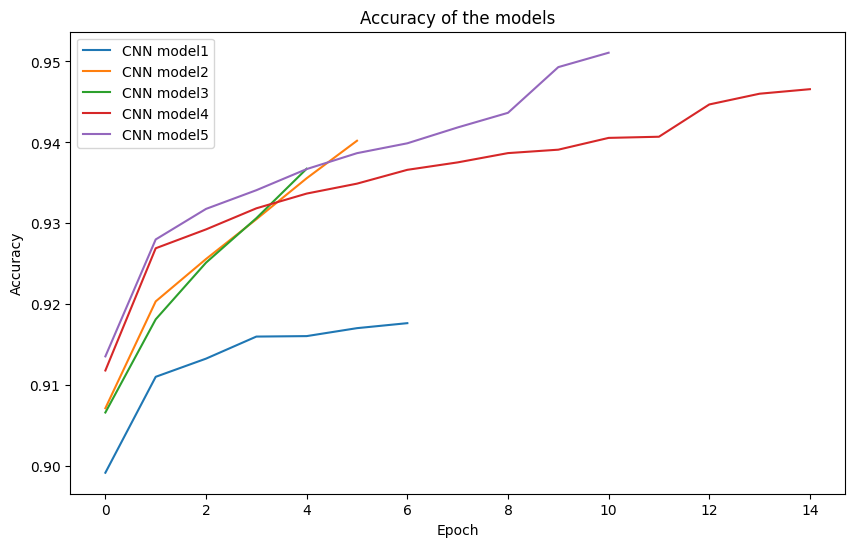

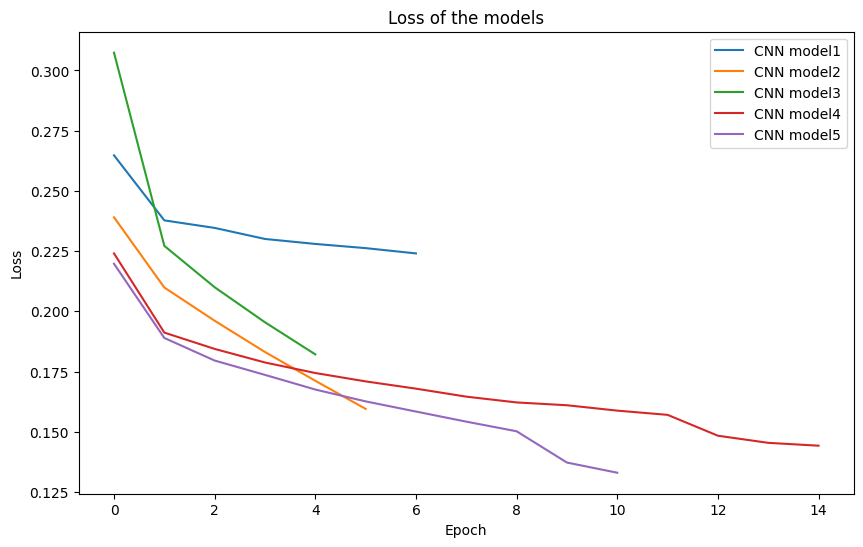

In [102]:
# Check which model is the best
cnn_model1 = tf.keras.models.load_model('Models/CNN_model1.h5')
cnn_model2 = tf.keras.models.load_model('Models/CNN_model2.h5')
cnn_model3 = tf.keras.models.load_model('Models/CNN_model3.h5')
cnn_model4 = tf.keras.models.load_model('Models/CNN_model4.h5')
cnn_model5 = tf.keras.models.load_model('Models/CNN_model5.h5')

loss, accuracy = cnn_model1.evaluate(X_test, test_labels, verbose=0)
print('CNN model1: accuracy: %f, loss: %f' % (accuracy*100, loss))

loss, accuracy = cnn_model2.evaluate(X_test, test_labels, verbose=0)
print('CNN model2: accuracy: %f, loss: %f' % (accuracy*100, loss))

loss, accuracy = cnn_model3.evaluate(X_test, test_labels, verbose=0)
print('CNN model3: accuracy: %f, loss: %f' % (accuracy*100, loss))

loss, accuracy = cnn_model4.evaluate(X_test, test_labels, verbose=0)
print('CNN model4: accuracy: %f, loss: %f' % (accuracy*100, loss))

loss, accuracy = cnn_model5.evaluate(X_test, test_labels, verbose=0)
print('CNN model5: accuracy: %f, loss: %f' % (accuracy*100, loss))

# Plot the accuracy of the models
plt.figure(figsize=(10, 6))
plt.plot(cnn1_history.history['accuracy'], label='CNN model1')
plt.plot(cnn2_history.history['accuracy'], label='CNN model2')
plt.plot(cnn3_history.history['accuracy'], label='CNN model3')
plt.plot(cnn4_history.history['accuracy'], label='CNN model4')
plt.plot(cnn5_history.history['accuracy'], label='CNN model5')
plt.title('Accuracy of the models')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot the loss of the models
plt.figure(figsize=(10, 6))
plt.plot(cnn1_history.history['loss'], label='CNN model1')
plt.plot(cnn2_history.history['loss'], label='CNN model2')
plt.plot(cnn3_history.history['loss'], label='CNN model3')
plt.plot(cnn4_history.history['loss'], label='CNN model4')
plt.plot(cnn5_history.history['loss'], label='CNN model5')
plt.title('Loss of the models')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [133]:
# Save the best model
accuracies = [cnn1_accuracy, cnn2_accuracy, cnn3_accuracy, cnn4_accuracy, cnn5_accuracy]
models = [cnn_model1, cnn_model2, cnn_model3, cnn_model4, cnn_model5]
histories = [cnn1_history, cnn2_history, cnn3_history, cnn4_history, cnn5_history]

best_model = models[np.argmax(accuracies)]
best_model.save('Models/CNN_best_model.h5')

In [134]:
# Save the tokenizer
with open('Data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)